In [1]:
import numpy as np
import h5py
import os
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Load Data

In [2]:
with h5py.File('/home/guangyaoyang/data/dogBreed/resnet50_v2_pretrained_Xy.h5', 'r') as f:
    X_train_resnet50_v2 = np.array(f['X_train_resnet50_v2'])
    X_test_resnet50_v2 = np.array(f['X_test_resnet50_v2'])
    y_train = np.array(f['y_train'])
    
print ("X_train Size: ", X_train_resnet50_v2.shape)
print ("X_test Size: ", X_test_resnet50_v2.shape)
print ("y_train Size: ", y_train.shape)

X_train Size:  (10222, 2048)
X_test Size:  (10357, 2048)
y_train Size:  (10222,)


# Data Iterator

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_resnet50_v2, y_train, test_size=0.2)

# dataset
dataset_train = mx.gluon.data.ArrayDataset(nd.array(X_train), nd.array(y_train))
dataset_val = mx.gluon.data.ArrayDataset(nd.array(X_val), nd.array(y_val))

# data itet
batch_size = 128
data_iter_train = mx.gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
data_iter_val = mx.gluon.data.DataLoader(dataset_val, batch_size)

# Build Model

In [4]:
ctx = mx.gpu()
def get_net(ctx):

    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Dense(256, activation='relu'))
        net.add(nn.Dropout(0.5))
        net.add(nn.Dense(120))

    net.initialize(ctx=ctx)
    return net

# Training

In [5]:
def accuracy(output, labels):
    return nd.mean(nd.argmax(output, axis=1) == labels).asscalar()

def evaluate(net, data_iter):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    loss, acc, n = 0., 0., 0.
    steps = len(data_iter)
    for data, label in data_iter:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
        loss += nd.mean(softmax_cross_entropy(output, label)).asscalar()
    return loss/steps, acc/steps

In [6]:
def train(net, data_iter_train, data_iter_val, ctx, 
          epochs=50, lr=0.01, mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20):

    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(net.collect_params(),  'sgd', {'learning_rate': lr, 'momentum': mome, 
                                      'wd': wd})
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        steps = len(data_iter_train)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for X, y in data_iter_train:

            X, y = X.as_in_context(ctx), y.as_in_context(ctx)

            with mx.autograd.record():
                out = net(X)
                loss = softmax_cross_entropy(out, y)

            loss.backward()
            trainer.step(batch_size)

            train_loss += nd.mean(loss).asscalar()


            train_acc += accuracy(out, y)

        val_loss, val_acc = evaluate(net, data_iter_val)
        train_loss_list.append(train_loss/steps)
        val_loss_list.append(val_loss)
        print("Epoch %d. loss: %.4f, acc: %.2f%%, val_loss %.4f, val_acc %.2f%%" % (
            epoch+1, train_loss/steps, train_acc/steps*100, val_loss, val_acc*100))
        
    return train_loss_list, val_loss_list

In [7]:
net = get_net(ctx)
train_loss_list, val_loss_list = train(net, data_iter_train, data_iter_val, ctx, epochs=100, lr=0.01, \
      mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20)

Epoch 1. loss: 4.1521, acc: 13.40%, val_loss 2.7939, val_acc 53.78%
Epoch 2. loss: 2.1454, acc: 48.24%, val_loss 1.2305, val_acc 75.26%
Epoch 3. loss: 1.3052, acc: 64.59%, val_loss 0.8557, val_acc 78.87%
Epoch 4. loss: 1.0280, acc: 70.11%, val_loss 0.7375, val_acc 79.17%
Epoch 5. loss: 0.8942, acc: 73.60%, val_loss 0.6764, val_acc 80.29%
Epoch 6. loss: 0.8265, acc: 75.38%, val_loss 0.6434, val_acc 81.22%
Epoch 7. loss: 0.7720, acc: 76.28%, val_loss 0.6237, val_acc 80.97%
Epoch 8. loss: 0.7148, acc: 78.56%, val_loss 0.5937, val_acc 81.66%
Epoch 9. loss: 0.6776, acc: 79.76%, val_loss 0.5854, val_acc 81.51%
Epoch 10. loss: 0.6465, acc: 79.64%, val_loss 0.5993, val_acc 81.02%
Epoch 11. loss: 0.6242, acc: 80.81%, val_loss 0.5789, val_acc 81.27%
Epoch 12. loss: 0.6086, acc: 80.95%, val_loss 0.5714, val_acc 81.46%
Epoch 13. loss: 0.5849, acc: 82.03%, val_loss 0.5715, val_acc 81.85%
Epoch 14. loss: 0.5526, acc: 82.43%, val_loss 0.5604, val_acc 82.20%
Epoch 15. loss: 0.5432, acc: 83.20%, val_lo

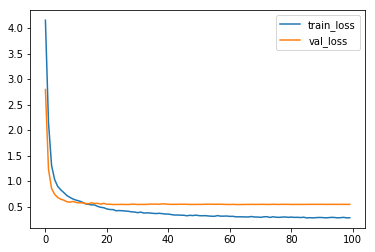

In [8]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()

(0, 1.5)

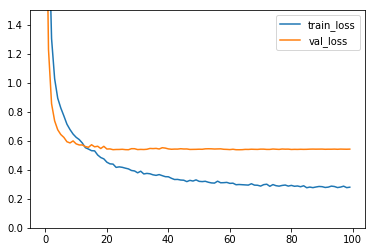

In [9]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()
plt.ylim([0,1.5])

# Testing

In [93]:
out_softmax = nd.softmax(net(nd.array(X_test_resnet50_v2).as_in_context(ctx)))

synsets = mx.gluon.data.vision.ImageFolderDataset("/home/guangyaoyang/data/dogBreed/train_gy").synsets
ids = sorted(os.listdir("/home/guangyaoyang/data/dogBreed/test_gy/0/"))
ids = [i[:-4] for i in ids]

df = pd.DataFrame(out_softmax.asnumpy())
df.columns = synsets
df["id"] = ids
df = df[["id"]+synsets]

In [104]:
df.to_csv('/home/guangyaoyang/data/dogBreed/pred2.csv', index=None)